# Perceptual Hash について

[本コンペでは画像データと.csv 形式の構造化データ](https://www.kaggle.com/c/shopee-product-matching/data?select=test_images)が与えてられている　<br>
csv データの中に `image_phash` というカラムがあったので、次の流れで perceptual hash (phash) について確認してみます
1. hash 値とは
2. phash 値とは

# 1. hash 値とは
データに対して適当な計算処理を施して得られた値のこと。この適当な計算処理を hash 関数（要約関数）と呼び、計算処理を工夫することで様々な hash 値を得ることがができる。次の数式を例にとると、$x$ が元データ、$f(\cdot)$ は hash 関数、$y$ が hash 値になります
$$y = f(x)$$
>ここでわかるのは、phash とは数ある hash 値の 1 つであるということ

## hash 値の具体例
何らかのデータ $x$ を登録するために、その格納位置を決定したいとします。このデータ $x$ は必ず整数になると仮定すると、$x$ を 100 で割った時の余りを格納位置とします。例えば、$x$ が 243 なら格納位置は "243%100" より 43 となります。
>この例はハッシュ探索と呼ばれるアルゴリズムで、ある値 $x$ を添字 index へと写像する関数 $f(x)$ が hash 関数であり、100 で割った時の剰余が hash 値です

†) 実際には、このハッシュ関数を利用したアルゴリズムでは、同じインデックスに複数のデータが格納されてしまう "衝突" と呼ばれる現象が発生してしまいます。この問題の解決策として、チェイン法やオープンアドレス法といったアルゴリズムがあるので、もし興味があれば勉強してみてください。 <br>
([新・明解Pythonで学ぶアルゴリズムとデータ構造](https://www.amazon.co.jp/%E6%96%B0%E3%83%BB%E6%98%8E%E8%A7%A3Python%E3%81%A7%E5%AD%A6%E3%81%B6%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0%E3%81%A8%E3%83%87%E3%83%BC%E3%82%BF%E6%A7%8B%E9%80%A0-%E6%96%B0%E3%83%BB%E6%98%8E%E8%A7%A3%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E6%9F%B4%E7%94%B0%E6%9C%9B%E6%B4%8B/dp/4815603197/ref=asc_df_4815603197/?tag=jpgo-22&linkCode=df0&hvadid=408675898008&hvpos=&hvnetw=g&hvrand=16204625806183202855&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=1009307&hvtargid=pla-857638842386&psc=1&th=1&psc=1) がおすすめです）

ref: https://programming-place.net/ppp/contents/algorithm/search/006.html

# 2. Perceptual Hash とは
ここまでで、hash 値とはデータに対して何らかの計算処理を施すことで求まることがわかったと思います。この hash 値には、"同じデータからは常に同じ hash 値が生成される" 特徴があります。この特徴に加えて phash では、"似ているデータからは近い値の hash 値が生成される" といった特徴があり、画像や動画、音声とといったマルメディアデータの `類似度` を求めることができます。また、phash には次の特徴もあります。
* hash 値は 64bit の 16 進数で得られる
* 得られた hash 値のハミング距離を求めることで、簡単に類似度を比較できる (同じ文字数の文字列を比較して、同じ位置の異なる文字数をカウントすることで簡単に算出できる）

†) Python では `imagehash` と呼ばれるライブラリを使用することで、簡単に phash を算出できます

## phash のアルゴリズム
1. 画像を $8\times8$ よりも大きいサイズにリサイズする（ex. $32\times32$）
2. グレイスケール化する
3. [離散コサイン変換（DCT）](https://jp.mathworks.com/help/images/discrete-cosine-transform.html)する。（画像をさまざま周波数のコサインに和に変換する。画像を様々な周波成分に分解するイメージ）
4. 低周波成分の $8\times8$ だけを取り出す
5. 直流成分を除いた低周波数成分の平均値を算出する
6. 平均値よりも高いか低いかで $8\times8$ 成分を 2 値化する
7. ラスタスキャン順など何らかの順で一列にしてから、64bit の hash 値に変換する

## コンペデータの phash を確認

In [2]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance

In [3]:
# データ確認
train_df = pd.read_csv('./dataset/train.csv')
train_df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


**同一画像で phash を確認**

In [4]:
def plotter(t_path, c_path, image_dir='./dataset/train_images'):
    fig, ax = plt.subplots(1, 2)
    t_im = plt.imread(os.path.join(image_dir, t_path))
    c_im = plt.imread(os.path.join(image_dir, c_path))
    ax[0].imshow(t_im)
    ax[0].axis('off')
    ax[1].imshow(c_im)
    ax[1].axis('off')
    plt.show()
    plt.close()

hamming distance is 0.000


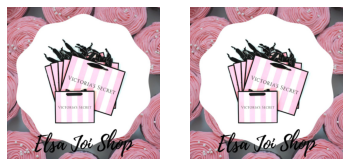

In [5]:
target_idx = 0
target_row = train_df.iloc[target_idx]
target_phash = target_row['image_phash']
print('hamming distance is %.3f'%distance.hamming(list(target_phash), list(target_phash)))
plotter(target_row['image'], target_row['image'])

**適当なサンプル同士で比較** <br>
phash は完全に一致していないので、ハミング距離は 1 

targe_hash: 94974f937d4c2433
comp_hash: af3f9460c2838f0f
hamming distance is 1.000


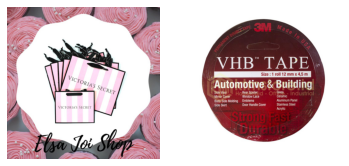

In [6]:
comp_row = train_df.iloc[target_idx+1]
comp_phash = comp_row['image_phash']
print('targe_hash: {}'.format(target_phash))
print('comp_hash: {}'.format(comp_phash))
print('hamming distance is %.3f'%distance.hamming(list(target_phash), list(comp_phash)))
plotter(target_row['image'], comp_row['image'])

**一行目の画像と最もハミング距離が近い画像を探してみる** <br>
なんか、背景が似てる画像を見つけることができました!

targe_hash: 94974f937d4c2433
min_hash: c4d71f137d43243c
hamming distance is 0.375


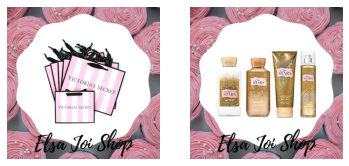

In [7]:
min_d = 1.0
for idx in range(1, len(train_df)):
    comp_row = train_df.iloc[idx]
    comp_phash = comp_row['image_phash']
    d = distance.hamming(list(target_phash), list(comp_phash))
    if d < min_d:
        min_d = d
        min_idx = idx

min_row = train_df.iloc[min_idx]
min_phash = min_row['image_phash']
print('targe_hash: {}'.format(target_phash))
print('min_hash: {}'.format(min_phash))
print('hamming distance is %.3f'%distance.hamming(list(target_phash), list(min_phash)))
plotter(target_row['image'], min_row['image'])